In [1]:
import os
import time
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
# wrapper so that model predicts using dask
from dask_ml.wrappers import ParallelPostFit  

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

from joblib import dump

import model_prep_and_evals as mpe 

In [2]:
# **************************************************************
# whole_set = True => merge train+test sets and train model with combined dataset
# whole_set = False => train model only with train set

whole_set = False

root = os.path.join(os.getcwd(), 'processing_results', 'model_2k')
train_name = 'model2k_train_2020.csv'
test_name = 'model2k_test_2020.csv'

first_feature = 'r'
last_feature = 'day_in_year'
label_name = 'iceplant'

# drops this feature
filter_year = True
year = 2020

save_model = True
model_name = 'model2k_2020_rfc'

calculate_feature_importance = False

In [3]:
# ------------------------------
# IMPORT TRAIN DATA
X_train = pd.read_csv(os.path.join(root, train_name)).loc[:, first_feature:last_feature]
y_train = pd.read_csv(os.path.join(root, train_name)).loc[:,label_name] 

# ------------------------------
# IMPORT TEST DATA
X_test = pd.read_csv(os.path.join(root, test_name)).loc[:, first_feature:last_feature]
y_test = pd.read_csv(os.path.join(root, test_name)).loc[:,label_name] 

# ------------------------------
if filter_year:
    
    X_train = X_train.loc[X_train.year == year]
    X_train = X_train.drop(['year'], axis =1)
    y_train = y_train.iloc[X_train.index]

    
    X_test = X_test.loc[X_test.year == year]
    X_test = X_test.drop(['year'], axis =1)
    y_test = y_test.iloc[X_test.index]
    
# ------------------------------
if whole_set == True:
    X_train = pd.concat([X_train, X_test], axis = 0)
    y_train = pd.concat([y_train, y_test], axis = 0)


X_test.columns == X_train.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [4]:
# ------------------------------
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [5]:
t0 = time.time()
rfc = ParallelPostFit(RandomForestClassifier(n_estimators = 100, 
                                             random_state = 42))
rfc.fit(X_train, y_train)
print(time.time() - t0)

if save_model:
    dump(rfc, model_name +'.joblib')

0.22154450416564941


In [6]:
if whole_set == False:
    preds = rfc.predict(X_test.to_numpy())
    mpe.print_accuracy_info(y_test.to_numpy(), preds)

true negatives: 421     false positives: 20
false negatives: 17     true positives: 69

sensitivity (TP/P): 80.23 %
specificity (TN/N): 95.46 %
G-mean:  0.88

precision (TP/(TP+FP)): 77.53 %

MCC:  0.7466507167944758

F1-measure:  0.78857
F0.5-measure (min false positives):  0.78054
F2-measure (min false negatives)  :  0.79677

accuracy: 92.98 %


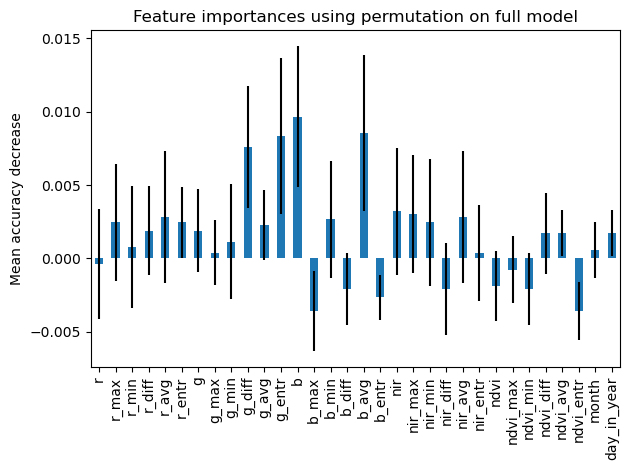

In [7]:
result = permutation_importance(
    rfc, 
    X_test.to_numpy(),
    y_test.to_numpy(),
    n_repeats=10, 
    random_state=42, 
    n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()